Sequential Game with game tree.

In [1]:
#import sys
#!{sys.executable} -m pip install pygraphviz

In [2]:
from itertools import chain, combinations, product
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
from collections import defaultdict

# Player & Value function

In [3]:
def v(s):
    # valuation of a coalition
    return 5 * int(len(s) >= 2)

In [4]:
class Player:
    def __init__(self, name, score):
        self.name = name
        self.score = score
    def __repr__(self):
        return self.name
    def __lt__(self, other):
        # <= operator
        return self.score < other.score
    def __le__(self, other):
        # <= operator
        return self.score <= other.score

In [5]:
def get_ranking(d):
    # d = {'A': abs_weight_A, 'B': abs_weight_B}
    return sorted(d.keys(),\
                              key=lambda player: d[player])
# https://stackoverflow.com/questions/4251732/fast-algorithm-to-calculate-delta-of-two-list
def delta_ranking(ranking_init, ranking_term):
    '''
    >>> ranking_init = ['album1', 'album2', 'album3']
    >>> ranking_term = ['album2', 'album1', 'album3']
    >>> return {'album1': 1, 'album3': 0, 'album2': -1}
    '''
    D = {k:v for v,k in enumerate(ranking_init)}
    return {k:v-D[k] for v,k in enumerate(ranking_term)}

In [6]:
albums_today = ['album1', 'album2', 'album3']
albums_yesterday = ['album2', 'album1', 'album3']
delta_ranking(albums_today, albums_yesterday)

{'album2': -1, 'album1': 1, 'album3': 0}

# State Representation

A set of players $N$.

A set of weights $W_0$.

A game state $G_t = (F, CS, t)$ where $CS$ is a partial coalition structure. $CS = \{(C_i, Z_i)\}_i$ where $C_i$ is a coalition and $Z_i$ indicates whether it's faithful or not!


We call coalition structure without $Z_i$ indicator a "semi"-coalition structure.

__How to enumerate game state__:

1. `powerset(N)` to get all possible F.
2. $F = N \setminus S$.
3. `Partition` all possible semi-coalition structure from $F$
4. For each CS of length $k$, use `product(range(2), k)` to generate all possible 0-1 length k sequence.

In [7]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [8]:
class PolicyState:
    def __init__(self, parentState, coalition_considered, state_num):
        self.parentState = parentState
        self.coalition_considered = coalition_considered
        self.state_num = state_num

In [9]:
class State:
    def __init__(self, F, CS, t):
        self.F = set(F) # FREE is a set
        self.CS = CS # coalition structure
        self.t = t
        self.name = 'G(' + 'F=' + str(self.F) + ',' + str(self.CS) + ',t=' + str(self.t) + ')'
    
    def __hash__(self):
        return hash(self.name)
    
    def __eq__(self, other):
        return self.name == self.name
    
    def __repr__(self):
        return self.name
    
    def evaluate(self):
        # this function should only be called for the very bottom horizon leaf 
        # nodes!
        # for leaf node, return dict {'A': delta_ranking, 'B':...}
        abs_weights_term = {}
        abs_weights_init = {}
        
        # free
        for agent in self.F:
            abs_weights_term[agent.name] = agent.score
            abs_weights_init[agent.name] = agent.score
        
        # coalition structure 
        for cs, z in zip(self.CS.CS, self.CS.Z):
            for agent in cs:
                abs_weights_term[agent.name] = agent.score + z*v(cs)
                abs_weights_init[agent.name] = agent.score
                
        ranking_init = get_ranking(abs_weights_init) 
        ranking_term = get_ranking(abs_weights_term)
        return delta_ranking(ranking_init, ranking_term)
        
        
    def expand_states(self, game):
        p = powerset(self.F)
        for C in p: # C is a aftermath new coalition!
            if not C:
                # new coalition proposed but everyone leave! 
                new_state = State(self.F, self.CS, self.t+1)
                #if new_state in game.nodes[self.t+1]:
                #    new_state = game.nodes[self.t+1][new_state]
                game.graph.add_edge(self, new_state)
                game.add_state(new_state)
                game.nodes[self.t+1].add(new_state)
                continue
            # else, C is no longer free!
            F_new = self.F.difference(C)
            # C can either be successful or lost
            for z in [0, 1]:
                if not F_new and not z:
                    continue # to avoid the case empty set F but Z = 0 indicating failure still
                CS_new = CoalitionStructure(self.CS.CS + [C], self.CS.Z + [z])
                new_state = State(F_new, CS_new, self.t+1) 
                game.graph.add_edge(self, new_state)
                #if new_state in game.nodes[self.t+1]:
                #    new_state = game.nodes[self.t+1][new_state]
                game.add_state(new_state)

In [10]:
class CoalitionStructure:
    def __init__(self, CS, Z):
        self.CS = CS # e.g. [{1}, {2,3}]
        self.Z = Z # e.g. (0, 1)
        self.name = 'CS(' + str(self.CS) + ',Z=' + str(self.Z) + ')'
    def __repr__(self):
        return self.name
    

In [11]:
class Game:
    def __init__(self, G0, graph, T):
        self.G0 = G0 # initial game state!
        self.graph = graph
        self.T = T # termination time
        self.nodes = defaultdict(set)
        self.nodes[0] = set([self.G0]) # key = time, value = list of nodes
        self.policyStates = []

    def build_graph(self):
        for t in range(self.T):
            nodes = self.nodes[t]
            for node in nodes:
                node.expand_states(self)
    def draw(self):
        pass
    
    def add_state(self, new_state):
        if new_state in self.nodes[new_state.t]:
            return
        self.nodes[new_state.t+1].add(new_state)

## Generate all states

In [12]:
# https://stackoverflow.com/questions/29762628/partition-of-a-set-or-all-possible-subgroups-of-a-list
def partitions(set_):
    if not set_:
        yield []
        return
    for i in range(int(2**len(set_)/2)):
        parts = [set(), set()]
        for item in set_:
            parts[i&1].add(item) # i & 1 ==> odd or even
            i >>= 1 # divide by 2
        for b in partitions(parts[1]):
            yield [parts[0]]+b

Generate some states for $N=\{A,B,C\}$ and $T=1$.

In [13]:
N = set([1,2,3])
p = powerset(N) # F and S

In [14]:
semi_states = [] # states without time
T = 1
for F in p:
    S = N.difference(F)
    for semi_CS in partitions(S):
        for Z in product(range(2), repeat=len(semi_CS)):
            CS = CoalitionStructure(semi_CS, Z)
            semi_states.append((F, CS))

In [15]:
combs = [
    semi_states,
    range(T+1)
]

states = [State(*semi_state, t) for semi_state, t in product(*combs)]
states

[G(F=set(),CS([{1, 2, 3}],Z=(0,)),t=0),
 G(F=set(),CS([{1, 2, 3}],Z=(0,)),t=1),
 G(F=set(),CS([{1, 2, 3}],Z=(1,)),t=0),
 G(F=set(),CS([{1, 2, 3}],Z=(1,)),t=1),
 G(F=set(),CS([{2, 3}, {1}],Z=(0, 0)),t=0),
 G(F=set(),CS([{2, 3}, {1}],Z=(0, 0)),t=1),
 G(F=set(),CS([{2, 3}, {1}],Z=(0, 1)),t=0),
 G(F=set(),CS([{2, 3}, {1}],Z=(0, 1)),t=1),
 G(F=set(),CS([{2, 3}, {1}],Z=(1, 0)),t=0),
 G(F=set(),CS([{2, 3}, {1}],Z=(1, 0)),t=1),
 G(F=set(),CS([{2, 3}, {1}],Z=(1, 1)),t=0),
 G(F=set(),CS([{2, 3}, {1}],Z=(1, 1)),t=1),
 G(F=set(),CS([{1, 3}, {2}],Z=(0, 0)),t=0),
 G(F=set(),CS([{1, 3}, {2}],Z=(0, 0)),t=1),
 G(F=set(),CS([{1, 3}, {2}],Z=(0, 1)),t=0),
 G(F=set(),CS([{1, 3}, {2}],Z=(0, 1)),t=1),
 G(F=set(),CS([{1, 3}, {2}],Z=(1, 0)),t=0),
 G(F=set(),CS([{1, 3}, {2}],Z=(1, 0)),t=1),
 G(F=set(),CS([{1, 3}, {2}],Z=(1, 1)),t=0),
 G(F=set(),CS([{1, 3}, {2}],Z=(1, 1)),t=1),
 G(F=set(),CS([{3}, {1, 2}],Z=(0, 0)),t=0),
 G(F=set(),CS([{3}, {1, 2}],Z=(0, 0)),t=1),
 G(F=set(),CS([{3}, {1, 2}],Z=(0, 1)),t=0),
 G(F

## DP State expansion

In [16]:
A = Player('A', 3)
B = Player('B', 2)
C = Player('C', 1)
N = set([A, B, C])

In [17]:
CS0 = CoalitionStructure(CS=[], Z=[])
G0 = State(N, CS0, t=0)
print('G0:', G0)
graph = nx.DiGraph()
T = 2
game = Game(G0, graph, T)

G0: G(F={C, A, B},CS([],Z=[]),t=0)


In [18]:
game.build_graph()

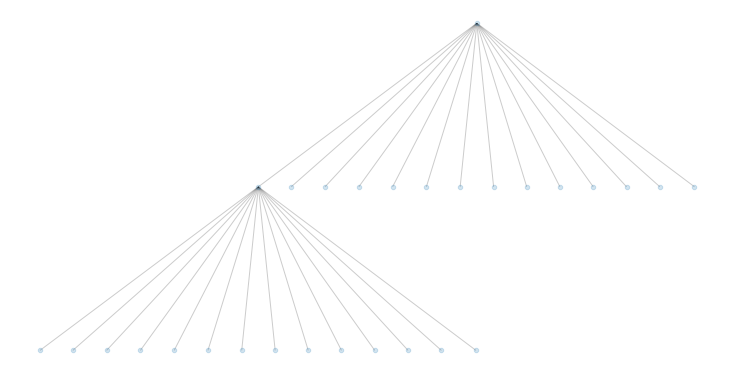

In [19]:
plt.rcParams['figure.figsize'] = 10, 5
pos =graphviz_layout(game.graph, prog='dot')
nx.draw(game.graph, pos,alpha=0.2, arrows=False, with_labels=False, node_size=20);

In [20]:
game.nodes

defaultdict(set,
            {0: {G(F={C, A, B},CS([],Z=[]),t=0)},
             1: {G(F={C, A, B},CS([],Z=[]),t=1)},
             2: {G(F=set(),CS([(C, A, B)],Z=[1]),t=1),
              G(F={A, B},CS([(C,)],Z=[0]),t=1),
              G(F={A, B},CS([(C,)],Z=[1]),t=1),
              G(F={A},CS([(C, B)],Z=[0]),t=1),
              G(F={A},CS([(C, B)],Z=[1]),t=1),
              G(F={B},CS([(C, A)],Z=[0]),t=1),
              G(F={B},CS([(C, A)],Z=[1]),t=1),
              G(F={C, A, B},CS([],Z=[]),t=1),
              G(F={C, A, B},CS([],Z=[]),t=2),
              G(F={C, A},CS([(B,)],Z=[0]),t=1),
              G(F={C, A},CS([(B,)],Z=[1]),t=1),
              G(F={C, B},CS([(A,)],Z=[0]),t=1),
              G(F={C, B},CS([(A,)],Z=[1]),t=1),
              G(F={C},CS([(A, B)],Z=[0]),t=1),
              G(F={C},CS([(A, B)],Z=[1]),t=1)},
             3: {G(F=set(),CS([(C, A, B)],Z=[1]),t=2),
              G(F={A, B},CS([(C,)],Z=[0]),t=2),
              G(F={A, B},CS([(C,)],Z=[1]),t=2),
              

In [21]:
leafs = list(game.nodes[T])
i = 22
# the bottom player group with the top player.
# middle player drops 1 in ranking! and bottom gains 1!
print(leafs[i])
leafs[i].evaluate()

IndexError: list index out of range

# Agent Policy Optimization